# HDBSCAN Clustering for RBD sequences - Omicron Only

Take a look at the clusters and the pango lineages in them (above).
- Cluster %: The percentage of a specific Pango lineage within a particular cluster, calculated as the number of occurrences of that lineage in the cluster divided by the total number of occurrences of all lineages in the cluster.
- Lineage %: The percentage of a specific Pango lineage's occurrences in a cluster relative to its total occurrences across the entire dataset.

Maybe better names would be Lineage Cluster %, Lineage Dataset %?

---
### Omicron only (all available) - From finetuned esm-mlm

In [1]:
import os
import pandas as pd

data_dir = "../../data/rbd"
parquet_file = os.path.join(data_dir, "spikeprot0528.clean.uniq.noX.RBD.metadata.variants.ADO_from-esm-mlm_CLS-embedded.parquet")
embedded_ado_df = pd.read_parquet(parquet_file, engine='fastparquet')

# Extract Omicron only
embedded_o_df = embedded_ado_df[embedded_ado_df['variant'].isin(["Omicron"])]
print(embedded_o_df['variant'].value_counts())

save_as = os.path.join(data_dir, f"spikeprot0528.clean.uniq.noX.RBD.metadata.variants.O_from-esm-mlm_CLS-embedded.parquet")
embedded_o_df.to_parquet(save_as, index=False)

variant
Omicron    160016
Name: count, dtype: int64


Apply tSNE to the embeddings.

In [2]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

def plot_tsne_grid(info_df, embedding_matrix, variant_column, color_map='tab20', perplexities=[5, 50, 100, 200, 400, 800, 1600, 1800, 2000]):
    n_rows = 3
    n_cols = 3
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(18, 15))
    plt.subplots_adjust(hspace=0.4, wspace=0.3)
    plt.rcParams['font.family'] = 'sans-serif'

    variant_labels = sorted(info_df[variant_column].unique())
    colors = sns.color_palette(color_map, len(variant_labels))
    variant_colors = dict(zip(variant_labels, colors))
    variant_colors['UNSPECIFIED'] = 'black'

    for ax, perp in zip(axes.flat, perplexities):
        tsne = TSNE(n_components=2, perplexity=perp, random_state=0)
        embedding = tsne.fit_transform(embedding_matrix)
        embeddings_df = pd.DataFrame(embedding, columns=['DIM_1', 'DIM_2']).reset_index(drop=True)
        df = pd.concat([info_df, embeddings_df], axis=1)
        df['colors'] = df[variant_column].map(variant_colors)

        for variant in variant_labels:
            subset = df[df[variant_column] == variant]
            ax.scatter(subset['DIM_1'], subset['DIM_2'], 
                       label=variant, c=[variant_colors[variant]], s=30, alpha=0.7)

        ax.set_title(f'Perplexity={perp}', fontsize=10)
        ax.set_xlabel('t-SNE Dim 1')
        ax.set_ylabel('t-SNE Dim 2')

    # Only show legend once in a free axis or the last axis
    handles, labels = ax.get_legend_handles_labels()
    fig.legend(handles, labels, loc='upper center', ncol=6, fontsize=10)

    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show()

# Load in the data
parquet_file = os.path.join(data_dir, f"spikeprot0528.clean.uniq.noX.RBD.metadata.variants.O_from-esm-mlm_CLS-embedded.parquet")
embedded_o_df = pd.read_parquet(parquet_file, engine='fastparquet')
embedding_matrix = np.vstack(embedded_o_df["embedding"])
info_df = embedded_o_df.drop(columns=["embedding"])

In [3]:
# Apply tSNE to reduce the dimensionality of the embedding matrix
perplexity = round(len(info_df) * 0.01)
print(perplexity) 
tsne_reducer = TSNE(n_components=2, perplexity=perplexity, learning_rate='auto', random_state=0)
embedding_matrix_reduced = tsne_reducer.fit_transform(embedding_matrix)

# Save the embedding
embeddings_df = pd.DataFrame(embedding_matrix_reduced, columns=['DIM_1', 'DIM_2']).reset_index(drop=True)
tsne_df = pd.concat([info_df, embeddings_df], axis=1)
save_as = os.path.join(data_dir, f"spikeprot0528.clean.uniq.noX.RBD.metadata.variants.O_CLS-embedded.tsne-perp{perplexity}.parquet")
tsne_df.to_parquet(save_as, engine='fastparquet')

1600


Load in the tSNE embeddings.

In [4]:
# Load the embedding
data_dir = "../../data/rbd"
perplexity = 1600
parquet_file = os.path.join(data_dir, f"parquets/tsne_embeddings/spikeprot0528.clean.uniq.noX.RBD.metadata.variants.O_CLS-embedded.tsne-perp_{perplexity}.parquet")
embedded_o_df = pd.read_parquet(parquet_file, engine='fastparquet')
embedding_matrix_reduced = embedded_o_df[['DIM_1', 'DIM_2']].values
info_df = embedded_o_df.drop(columns=['DIM_1', 'DIM_2'])

Find the highest Silhouette Coefficient and Adjusted Rand Index.

In [65]:
for i in [100, 150, 200, 225, 250, 500, 750]:
    for j in [1000, 5000, 10000, 12500, 15000, 25000]:
        # Cluster
        hdb_labels = hdbscan.HDBSCAN(
            min_samples=i,
            min_cluster_size=j,
            core_dist_n_jobs=-1  # Enable parallel processing
        ).fit(embedding_matrix_reduced).labels_

        # Evaluate clustering
        silhouette_avg = silhouette_score(embedding_matrix_reduced, hdb_labels)
        ari = adjusted_rand_score(info_df["variant"], hdb_labels)
        print(f"min_sample {i}, min_cluster_size {j}: (Silhouette Coefficient {silhouette_avg:.2f}, Adjusted Rand Index {ari:.2f})")

min_sample 100, min_cluster_size 1000: (Silhouette Coefficient 0.30, Adjusted Rand Index 0.00)
min_sample 100, min_cluster_size 5000: (Silhouette Coefficient 0.40, Adjusted Rand Index 0.00)
min_sample 100, min_cluster_size 10000: (Silhouette Coefficient 0.41, Adjusted Rand Index 0.00)
min_sample 100, min_cluster_size 12500: (Silhouette Coefficient 0.41, Adjusted Rand Index 0.00)
min_sample 100, min_cluster_size 15000: (Silhouette Coefficient 0.41, Adjusted Rand Index 0.00)
min_sample 100, min_cluster_size 25000: (Silhouette Coefficient 0.48, Adjusted Rand Index 0.00)
min_sample 150, min_cluster_size 1000: (Silhouette Coefficient 0.34, Adjusted Rand Index 0.00)
min_sample 150, min_cluster_size 5000: (Silhouette Coefficient 0.45, Adjusted Rand Index 0.00)
min_sample 150, min_cluster_size 10000: (Silhouette Coefficient 0.45, Adjusted Rand Index 0.00)
min_sample 150, min_cluster_size 12500: (Silhouette Coefficient 0.45, Adjusted Rand Index 0.00)
min_sample 150, min_cluster_size 15000: (Sil

Plotting the tSNE embeddings after applying HDBSCAN.

min_sample 250, min_cluster_size 15000: Silhouette Coefficient: 0.57, Adjusted Rand Index: 0.00


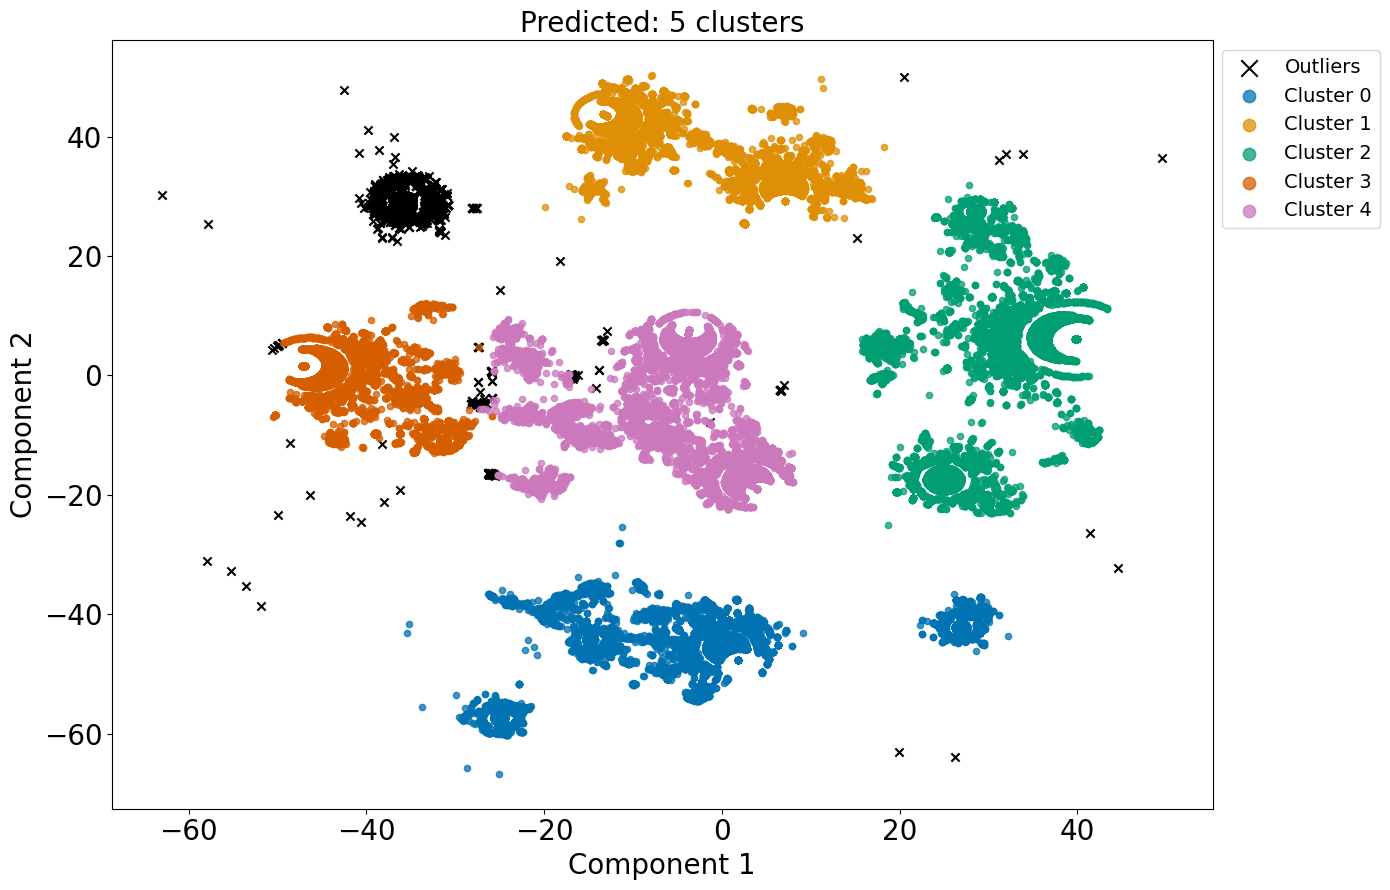

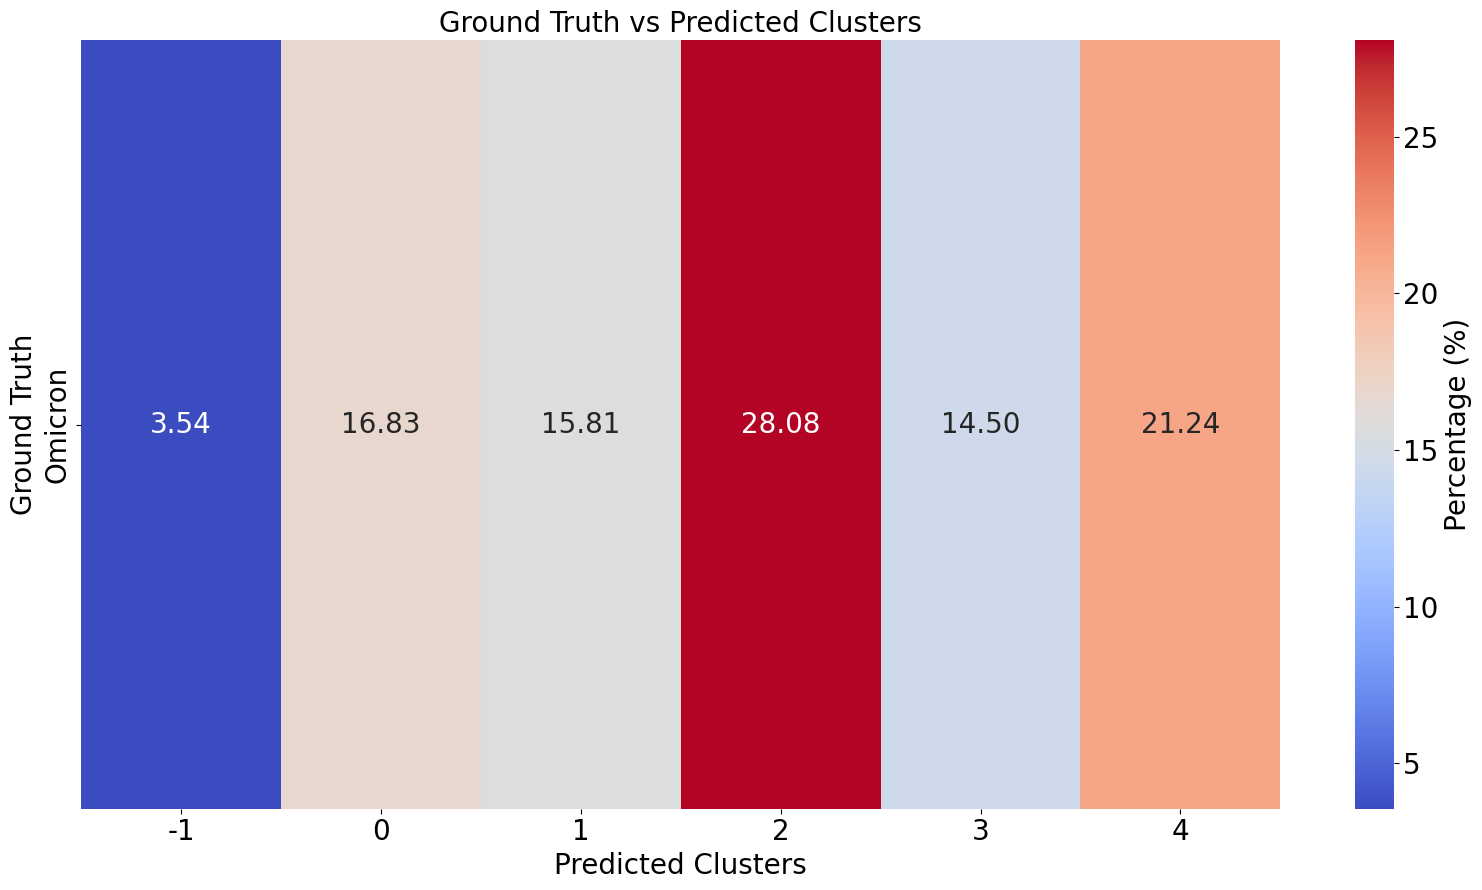

Predicted Clusters    -1      0      1      2      3      4
Ground Truth                                               
Omicron             5672  26932  25299  44930  23199  33984
   Cluster  variant Pango lineage  Cluster %  Lineage %
0       -1  Omicron      BA.2.12*  75.229196  79.921334
1       -1  Omicron          BA.2   5.553597   2.260820
2       -1  Omicron       BA.5.2*   2.997179   1.067370
3       -1  Omicron       BA.5.1*   1.904090   1.414724
4       -1  Omicron    Unassigned   1.763047   1.550147

   Cluster  variant Pango lineage  Cluster %  Lineage %
0        0  Omicron      XBB.1.5*  30.198277  99.632488
1        0  Omicron       CH.1.1*   9.702213  99.467073
2        0  Omicron       BN.1.3*   5.094312  99.061372
3        0  Omicron      BA.2.75*   4.470518  95.102686
4        0  Omicron         XBB.1   4.381405  99.578059

   Cluster  variant Pango lineage  Cluster %  Lineage %
0        1  Omicron       BQ.1.1*  41.444326  96.823345
1        1  Omicron       BA.4.6* 

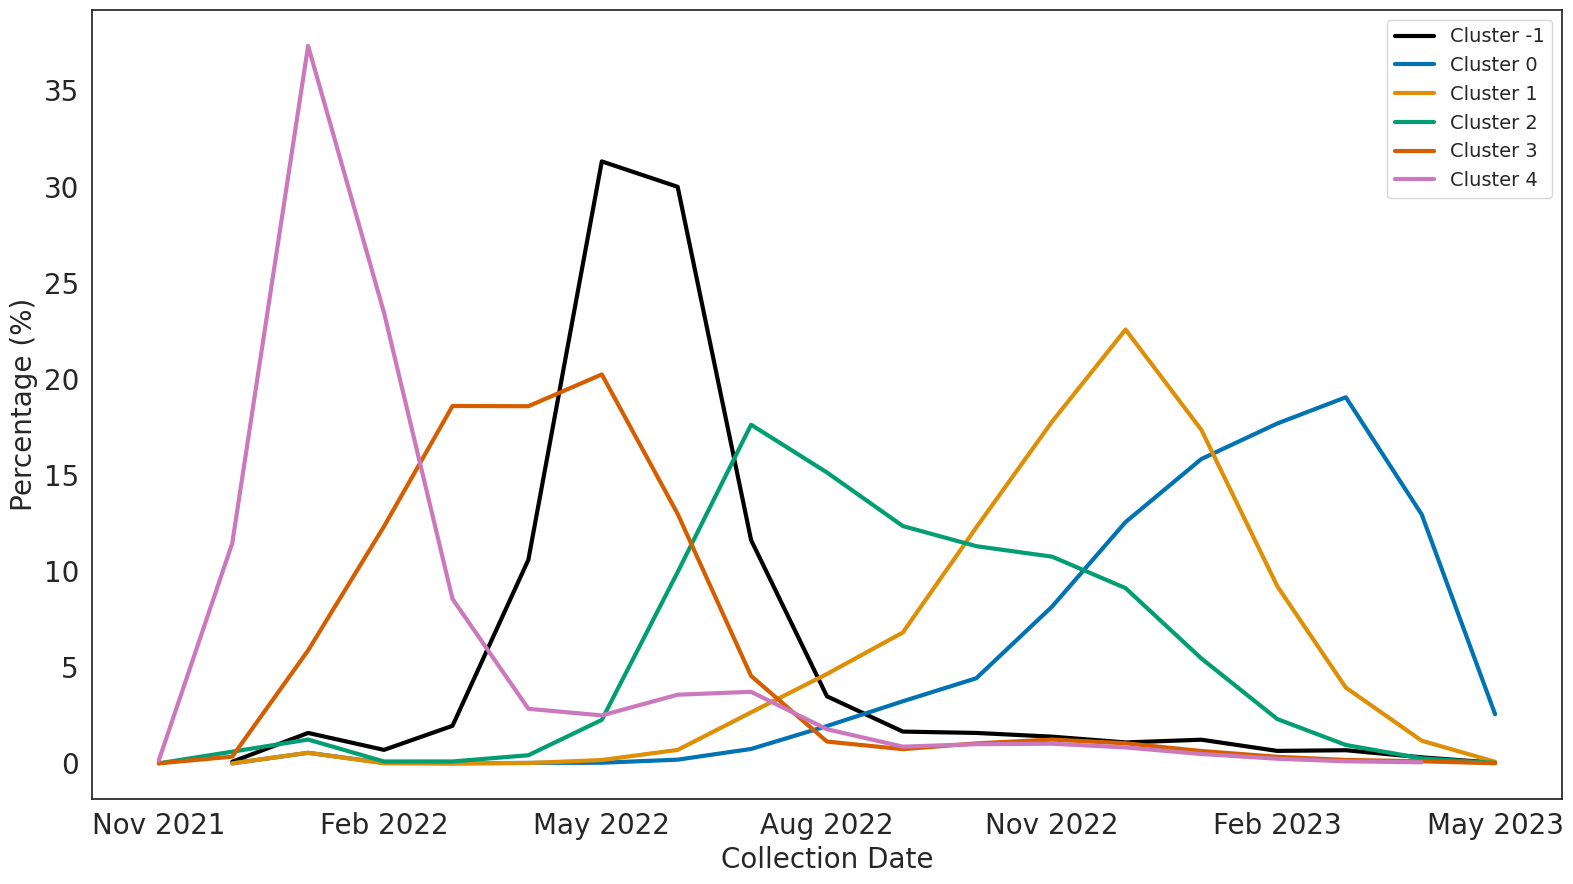

In [5]:
min_samples=250
min_cluster_size=15000

# Cluster
hdb_labels = hdbscan.HDBSCAN(
    min_samples=min_samples,
    min_cluster_size=min_cluster_size,
    core_dist_n_jobs=-1  # Enable parallel processing
).fit(embedding_matrix_reduced).labels_

# Evaluate clustering
silhouette_avg = silhouette_score(embedding_matrix_reduced, hdb_labels)
ari = adjusted_rand_score(info_df["variant"], hdb_labels)
print(f"min_sample {min_samples}, min_cluster_size {min_cluster_size}: Silhouette Coefficient: {silhouette_avg:.2f}, Adjusted Rand Index: {ari:.2f}")
save_as = f"../../results/plots/clustering/RBD.O.tSNE-perp{perplexity}.HDBSCAN-ms{min_samples}_mcs{min_cluster_size}-sc{silhouette_avg:.2f}_ari{ari:.2f}"
plot_hdbscan_predictions(save_as, info_df, embedding_matrix_reduced, hdb_labels, "variant", "colorblind")

# Create the truth table
plot_hdbscan_truthtable_heatmap(save_as, info_df, hdb_labels, "variant")

truth_table = pd.crosstab(info_df["variant"], hdb_labels, 
                                rownames=['Ground Truth'], 
                                colnames=['Predicted Clusters'])
print(truth_table)

# Cluster info
info_df['Cluster'] = hdb_labels
result = cluster_pango_lineage(info_df, 5)

clusters = result['Cluster'].unique()
clustered_dataframes = split_dataframe_by_cluster(result)

for cluster in clusters:
    print(f"{clustered_dataframes[cluster]}\n")

cluster_date_collected(save_as, info_df, hdb_labels, "colorblind")

We'll use the one below since it separates the clusters a little more.

min_sample 250, min_cluster_size 5000: Silhouette Coefficient: 0.43, Adjusted Rand Index: 0.00


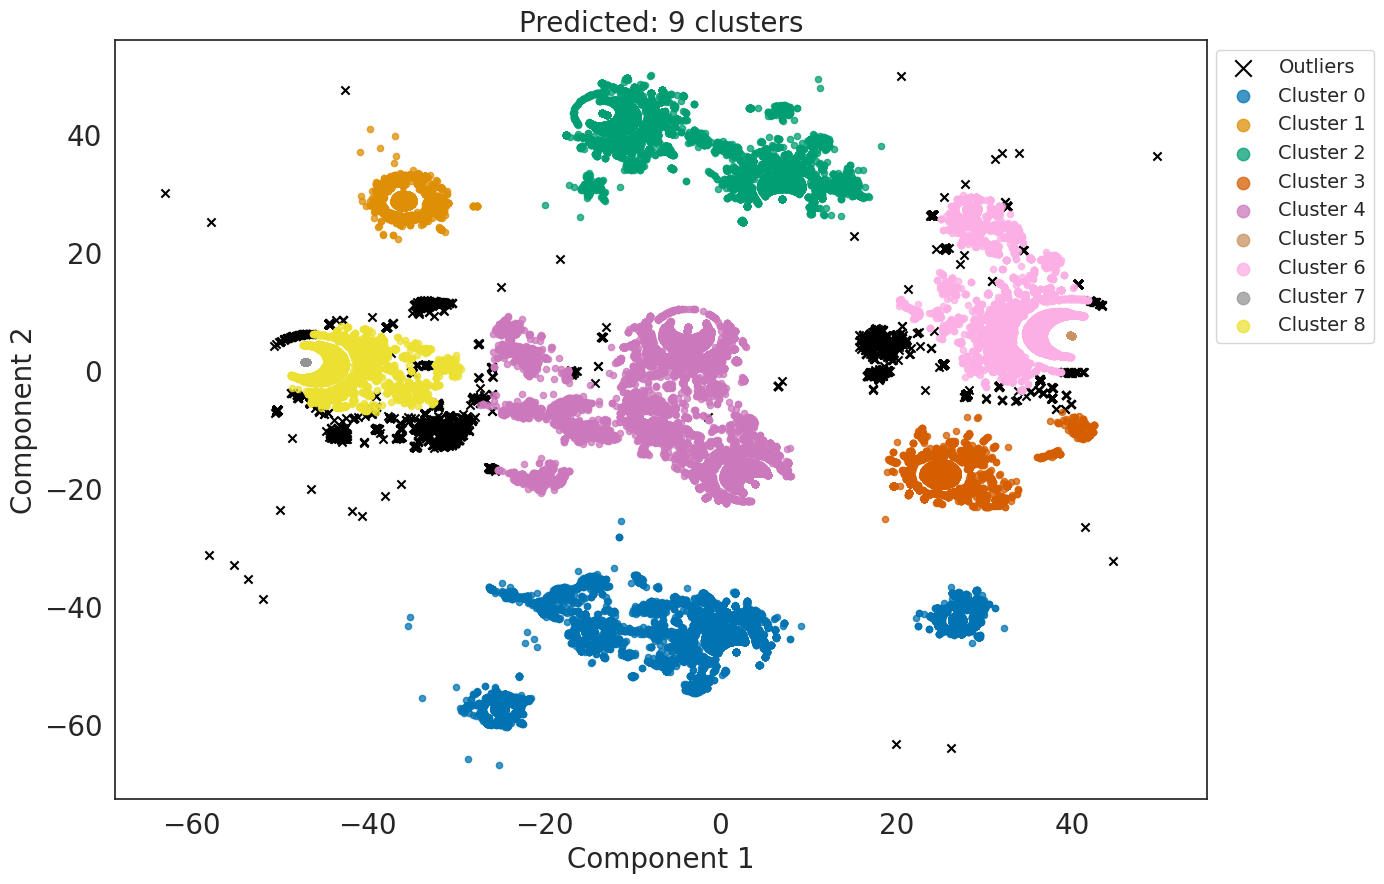

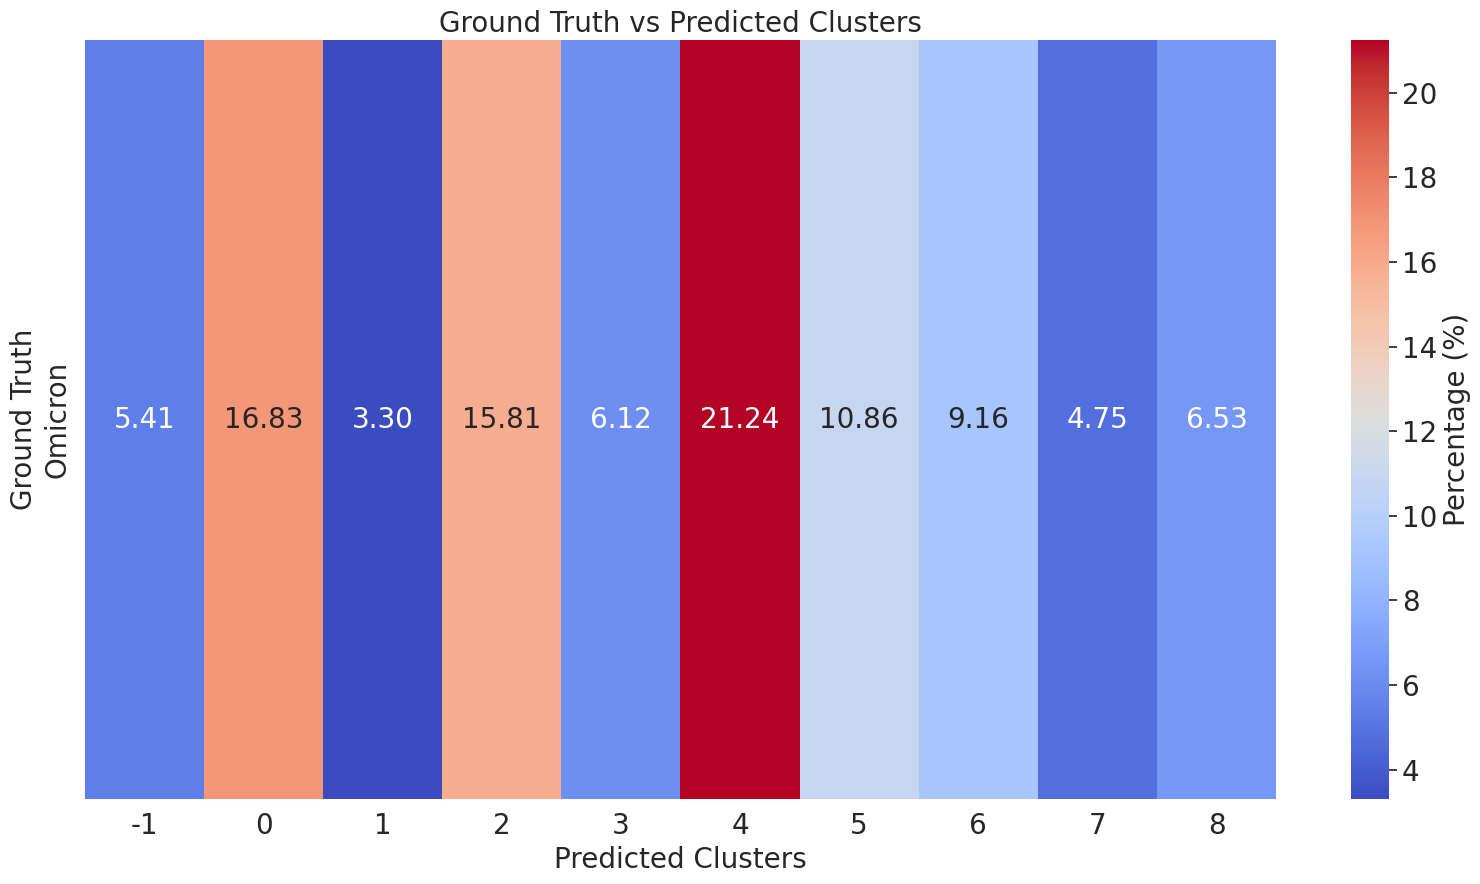

Predicted Clusters    -1      0     1      2     3      4      5      6     7  \
Ground Truth                                                                    
Omicron             8650  26932  5281  25299  9787  33984  17375  14663  7597   

Predicted Clusters      8  
Ground Truth               
Omicron             10448  
   Cluster  variant Pango lineage  Cluster %  Lineage %
0       -1  Omicron          BA.2  22.867052  14.196512
1       -1  Omicron       BA.5.2*  11.075145   6.014943
2       -1  Omicron       BA.2.3*   7.063584  24.627166
3       -1  Omicron       BA.5.1*   6.242775   7.073618
4       -1  Omicron       BA.2.9*   4.485549  17.414722

   Cluster  variant Pango lineage  Cluster %  Lineage %
0        0  Omicron      XBB.1.5*  30.198277  99.632488
1        0  Omicron       CH.1.1*   9.702213  99.467073
2        0  Omicron       BN.1.3*   5.094312  99.061372
3        0  Omicron      BA.2.75*   4.470518  95.102686
4        0  Omicron         XBB.1   4.381405  99.578059

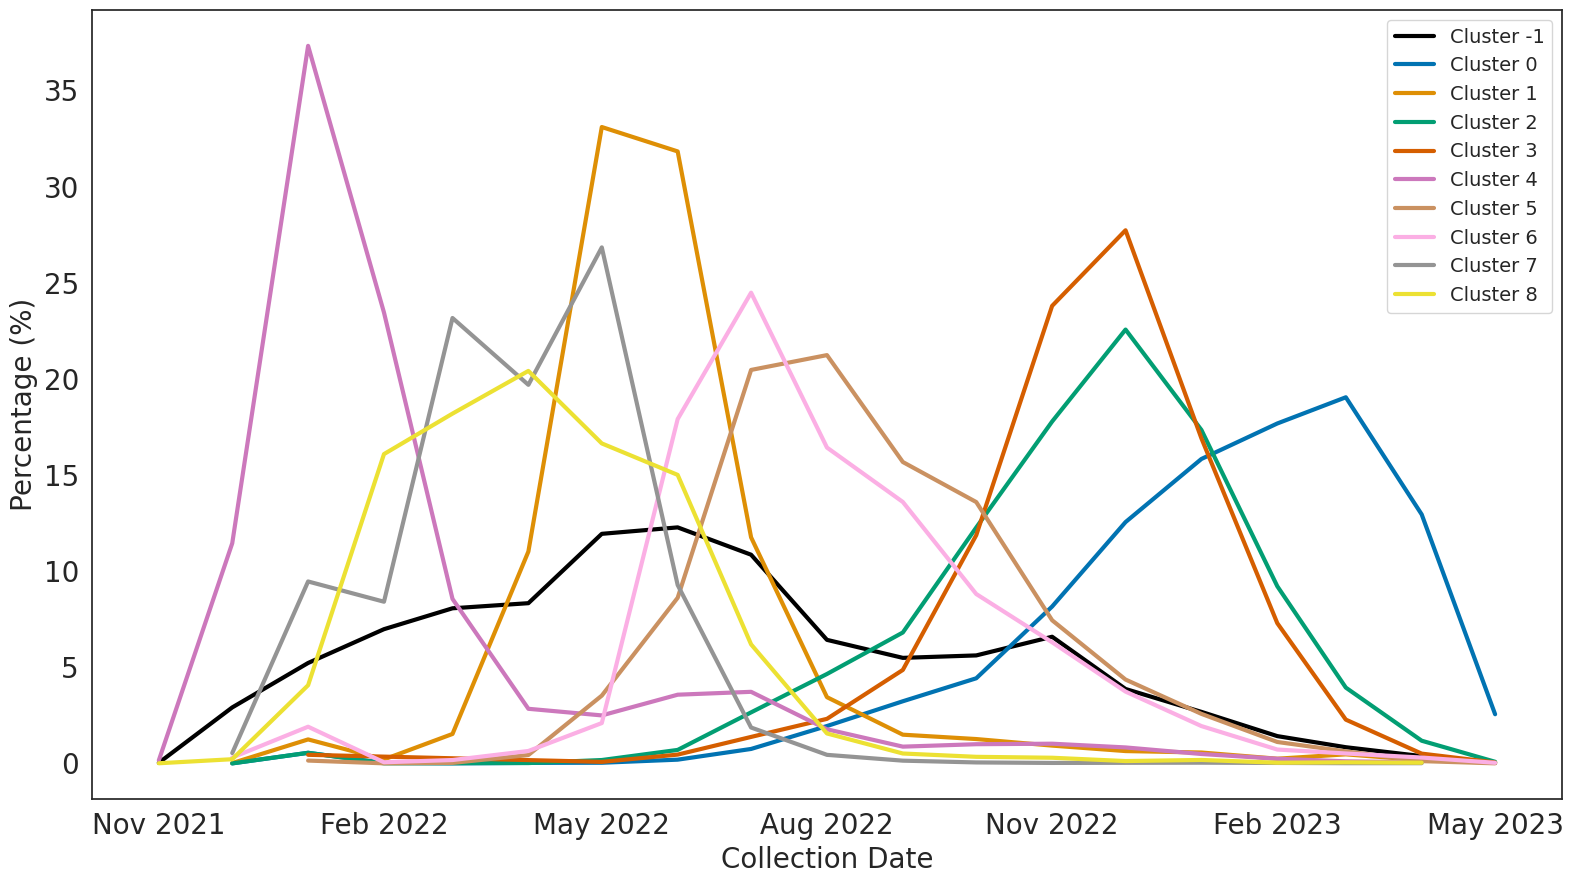

In [6]:
min_samples=250
min_cluster_size=5000

# Cluster
hdb_labels = hdbscan.HDBSCAN(
    min_samples=min_samples,
    min_cluster_size=min_cluster_size,
    core_dist_n_jobs=-1  # Enable parallel processing
).fit(embedding_matrix_reduced).labels_

# Evaluate clustering
silhouette_avg = silhouette_score(embedding_matrix_reduced, hdb_labels)
ari = adjusted_rand_score(info_df["variant"], hdb_labels)
print(f"min_sample {min_samples}, min_cluster_size {min_cluster_size}: Silhouette Coefficient: {silhouette_avg:.2f}, Adjusted Rand Index: {ari:.2f}")
save_as = f"../../results/plots/clustering/RBD.O.tSNE-perp{perplexity}.HDBSCAN-ms{min_samples}_mcs{min_cluster_size}-sc{silhouette_avg:.2f}_ari{ari:.2f}"
plot_hdbscan_predictions(save_as, info_df, embedding_matrix_reduced, hdb_labels, "variant", "colorblind")

# Create the truth table
plot_hdbscan_truthtable_heatmap(save_as, info_df, hdb_labels, "variant")

truth_table = pd.crosstab(info_df["variant"], hdb_labels, 
                                rownames=['Ground Truth'], 
                                colnames=['Predicted Clusters'])
print(truth_table)

# Cluster info
info_df['Cluster'] = hdb_labels
result = cluster_pango_lineage(info_df, 5)

clusters = result['Cluster'].unique()
clustered_dataframes = split_dataframe_by_cluster(result)

for cluster in clusters:
    print(f"{clustered_dataframes[cluster]}\n")

cluster_date_collected(save_as, info_df, hdb_labels, "colorblind")